In [49]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from gensim.models import KeyedVectors
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
import joblib

In [3]:
!pip install gdown

In [4]:
# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import gdown

# File ID from the Google Drive shareable link
file_id = '1pexbKsezfklXDaF6sI_YhTU8fSJAIgpP'
# URL to be used with gdown
gdown_url = f'https://drive.google.com/uc?id={file_id}'

# Download the file
gdown.download(gdown_url, 'data.csv', quiet=False)

# Read the CSV file into a DataFrame
data = pd.read_csv('data.csv', encoding='utf-8')
data.head()

Downloading...
From (original): https://drive.google.com/uc?id=1pexbKsezfklXDaF6sI_YhTU8fSJAIgpP
From (redirected): https://drive.google.com/uc?id=1pexbKsezfklXDaF6sI_YhTU8fSJAIgpP&confirm=t&uuid=78ee58e0-0cfd-4296-a504-29df72be9b35
To: /content/data.csv
100%|██████████| 266M/266M [00:05<00:00, 52.8MB/s]


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories           28332 non-null  object 
 7   primaryCategories    28332 non-null  object 
 8   imageURLs            28332 non-null  object 
 9   keys                 28332 non-null  object 
 10  manufacturer         28332 non-null  object 
 11  manufacturerNumber   28332 non-null  object 
 12  reviews.date         28332 non-null  object 
 13  reviews.dateSeen     28332 non-null  object 
 14  reviews.didPurchase  9 non-null      object 
 15  reviews.doRecommend  16086 non-null 

In [8]:
# Get unique values
unique_values = data['primaryCategories'].unique()

print(unique_values)

['Health & Beauty' 'Electronics' 'Office Supplies'
 'Animals & Pet Supplies' 'Home & Garden' 'Electronics,Furniture'
 'Toys & Games,Electronics' 'Electronics,Media'
 'Office Supplies,Electronics']


In [9]:
data = data[["dateAdded", "primaryCategories", "reviews.username", "brand", "reviews.text", "reviews.title", "reviews.rating"]]

data.head()

,dateAdded,primaryCategories,reviews.username,brand,reviews.text,reviews.title,reviews.rating
0,2015-10-30T08:59:32Z,Health & Beauty,Byger yang,Amazonbasics,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,3
1,2015-10-30T08:59:32Z,Health & Beauty,ByMG,Amazonbasics,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,4
2,2015-10-30T08:59:32Z,Health & Beauty,BySharon Lambert,Amazonbasics,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,5
3,2015-10-30T08:59:32Z,Health & Beauty,Bymark sexson,Amazonbasics,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,5
4,2015-10-30T08:59:32Z,Health & Beauty,Bylinda,Amazonbasics,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,5


In [10]:
# Concatenate
data['reviews.text'] = data['reviews.text'] + ' ' + data['reviews.title']

data.head()

,dateAdded,primaryCategories,reviews.username,brand,reviews.text,reviews.title,reviews.rating
0,2015-10-30T08:59:32Z,Health & Beauty,Byger yang,Amazonbasics,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,3
1,2015-10-30T08:59:32Z,Health & Beauty,ByMG,Amazonbasics,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,4
2,2015-10-30T08:59:32Z,Health & Beauty,BySharon Lambert,Amazonbasics,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,5
3,2015-10-30T08:59:32Z,Health & Beauty,Bymark sexson,Amazonbasics,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,5
4,2015-10-30T08:59:32Z,Health & Beauty,Bylinda,Amazonbasics,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,5


In [11]:
data = pd.DataFrame(data)

# Convert the 'dateAdded' column to datetime format
data['dateAdded'] = pd.to_datetime(data['dateAdded'])

# Extract the year and create a new column 'year'
data['year'] = data['dateAdded'].dt.year

# Drop column
data.drop(['dateAdded'], axis=1, inplace=True)

# Display the resulting DataFrame
data.head()

,primaryCategories,reviews.username,brand,reviews.text,reviews.title,reviews.rating,year
0,Health & Beauty,Byger yang,Amazonbasics,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,3,2015
1,Health & Beauty,ByMG,Amazonbasics,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,4,2015
2,Health & Beauty,BySharon Lambert,Amazonbasics,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,5,2015
3,Health & Beauty,Bymark sexson,Amazonbasics,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,5,2015
4,Health & Beauty,Bylinda,Amazonbasics,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,5,2015


In [12]:
# Check for missing values in the entire DataFrame
missing_values = data.isnull().sum()

# Display the count of missing values for each column
print(missing_values)

primaryCategories    0
reviews.username     5
brand                0
reviews.text         0
reviews.title        0
reviews.rating       0
year                 0
dtype: int64


In [13]:
# Remove rows where 'reviews.username' is empty
data = data.dropna(subset=['reviews.username'])

# Check for missing values in the entire DataFrame
missing_values = data.isnull().sum()

print (missing_values)
data.head()

primaryCategories    0
reviews.username     0
brand                0
reviews.text         0
reviews.title        0
reviews.rating       0
year                 0
dtype: int64


,primaryCategories,reviews.username,brand,reviews.text,reviews.title,reviews.rating,year
0,Health & Beauty,Byger yang,Amazonbasics,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,3,2015
1,Health & Beauty,ByMG,Amazonbasics,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,4,2015
2,Health & Beauty,BySharon Lambert,Amazonbasics,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,5,2015
3,Health & Beauty,Bymark sexson,Amazonbasics,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,5,2015
4,Health & Beauty,Bylinda,Amazonbasics,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,5,2015


In [14]:
# Get the value counts for the 'reviews.rating' column
rating_counts = data['reviews.rating'].value_counts()
print(rating_counts)

reviews.rating
5    19893
4     5648
3     1206
1      965
2      615
Name: count, dtype: int64


In [15]:
# Function to determine negative, neutral and positive
def review_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [3]:
        return "neutral"
    elif rating in [4, 5]:
        return "positive"
    else:
        return None

In [16]:

# Apply the reviews rating
data['sentiment'] = data['reviews.rating'].apply(review_sentiment)
data.head()



,primaryCategories,reviews.username,brand,reviews.text,reviews.title,reviews.rating,year,sentiment
0,Health & Beauty,Byger yang,Amazonbasics,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,3,2015,neutral
1,Health & Beauty,ByMG,Amazonbasics,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,4,2015,positive
2,Health & Beauty,BySharon Lambert,Amazonbasics,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,5,2015,positive
3,Health & Beauty,Bymark sexson,Amazonbasics,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,5,2015,positive
4,Health & Beauty,Bylinda,Amazonbasics,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,5,2015,positive


In [17]:
# Optionally we can now drop the reviews rating column, if we are just going to use sentiment.
data.drop(['reviews.rating'], axis=1, inplace=True)
data.head()

,primaryCategories,reviews.username,brand,reviews.text,reviews.title,year,sentiment
0,Health & Beauty,Byger yang,Amazonbasics,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,2015,neutral
1,Health & Beauty,ByMG,Amazonbasics,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,2015,positive
2,Health & Beauty,BySharon Lambert,Amazonbasics,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,2015,positive
3,Health & Beauty,Bymark sexson,Amazonbasics,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,2015,positive
4,Health & Beauty,Bylinda,Amazonbasics,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,2015,positive


In [18]:
# Download NLTK data files (run this once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# Tokenization and Lemmatization
lemmatizer = WordNetLemmatizer()

In [20]:
# Download NLTK stopwords
stop_words = set(stopwords.words('english'))

In [21]:
# Function to clean and lemmatize text data
def clean_and_lemmatize_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters and punctuation
    text = re.sub(r'[\u00BA\u00C4\u00C5\u00D4\u00E3\u00E8\u00EC\u00F2\u00F4\u00F9\u00FA\u0192]+', '', text)  # Remove specified characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove unnecessary whitespace
    words = text.split()  # Tokenize the text

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Lemmatize each word
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)  # Rejoin the words into a single string

In [22]:
data['reviews.text'] = data['reviews.text'].apply(clean_and_lemmatize_text)

In [23]:
tokenizer = Tokenizer()

In [24]:
# Fit the tokenizer on the review.text data
tokenizer.fit_on_texts(data['reviews.text'])

In [25]:
# Create word index
word_index = tokenizer.word_index

In [26]:
print(f"Number of unique words: {len(word_index)}")

Number of unique words: 12089


In [27]:
# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(data['reviews.text'])

In [28]:
# Pad sequences to ensure uniform length
max_length = max(len(seq) for seq in sequences)  # Find the maximum length of sequences
X = pad_sequences(sequences, maxlen=max_length)

In [29]:
rating_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

In [31]:
data['encoded_rating'] = data['sentiment'].map(rating_mapping)

In [32]:
print(data['encoded_rating'].unique())

[1 2 0]


In [33]:
data['reviews.rating'] = data['encoded_rating']
data.drop(columns=['encoded_rating'], inplace=True)

In [34]:
y = data['reviews.rating']

In [35]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [36]:
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (22661, 749)
Validation set size: (2833, 749)
Test set size: (2833, 749)


In [37]:
# Download the GloVe embeddings file directly to Colab
!gdown --id 1Y6PTK6mo9fBk5Y1THmN47Ip5NNiFSNe0 -O /content/glove.6B.100d.txt

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Y6PTK6mo9fBk5Y1THmN47Ip5NNiFSNe0
From (redirected): https://drive.google.com/uc?id=1Y6PTK6mo9fBk5Y1THmN47Ip5NNiFSNe0&confirm=t&uuid=99ed9f81-8293-4ee5-9756-cf413ea100e2
To: /content/glove.6B.100d.txt
100% 347M/347M [00:07<00:00, 45.9MB/s]


In [38]:
# Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare the embedding matrix
embedding_dim = 100  # GloVe embedding dimension

vocab_size = len(word_index) + 1 # Add 1 for the unknown words

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")


Embedding matrix shape: (12090, 100)


In [39]:
y_train.shape

(22661,)

In [40]:
# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [41]:
num_classes = 3

# One-hot encode
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

In [42]:
y_train_one_hot.shape

(22661, 3)

In [43]:
# Initialize an LSTM model
model = Sequential()

# Add an Embedding layer using the embedding_matrix as weights
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True))

# Add Bidirectional LSTM layer 1
model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Add Bidirectional LSTM layer 2
model.add(Bidirectional(LSTM(128)))

# Add a Dense layer
model.add(Dense(64, activation='relu'))

# Add Dropout layer
model.add(Dropout(0.3))

# Add output layer for classification
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 749, 100)          1209000   
                                                                 
 bidirectional (Bidirection  (None, 749, 256)          234496    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

In [44]:
# Example usage in your model training
history = model.fit(X_train, y_train_one_hot, epochs=10, batch_size=256, validation_data=(X_val, y_val_one_hot))

Epoch 1/10
89/89 [==============================] - 31s 262ms/step - loss: 0.3439 - accuracy: 0.9024 - val_loss: 0.2342 - val_accuracy: 0.9206
Epoch 2/10
89/89 [==============================] - 19s 219ms/step - loss: 0.2041 - accuracy: 0.9336 - val_loss: 0.2006 - val_accuracy: 0.9322
Epoch 3/10
89/89 [==============================] - 17s 194ms/step - loss: 0.1610 - accuracy: 0.9443 - val_loss: 0.1857 - val_accuracy: 0.9375
Epoch 4/10
89/89 [==============================] - 16s 183ms/step - loss: 0.1303 - accuracy: 0.9561 - val_loss: 0.1725 - val_accuracy: 0.9453
Epoch 5/10
89/89 [==============================] - 14s 161ms/step - loss: 0.1051 - accuracy: 0.9664 - val_loss: 0.1759 - val_accuracy: 0.9495
Epoch 6/10
89/89 [==============================] - 14s 159ms/step - loss: 0.0840 - accuracy: 0.9741 - val_loss: 0.1781 - val_accuracy: 0.9492
Epoch 7/10
89/89 [==============================] - 14s 153ms/step - loss: 0.0696 - accuracy: 0.9796 - val_loss: 0.1800 - val_accuracy: 0.9527

In [45]:
# Make predictions on validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded y_val_one_hot back to categorical labels
y_val_true = np.argmax(y_val_one_hot, axis=1)

# Print classification report
print(classification_report(y_val_true, y_val_pred_classes))

89/89 [==============================] - 4s 34ms/step
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       158
           1       0.65      0.65      0.65       120
           2       0.98      0.99      0.98      2555

    accuracy                           0.96      2833
   macro avg       0.83      0.79      0.81      2833
weighted avg       0.96      0.96      0.96      2833



In [46]:
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test_one_hot, axis=1)
print(classification_report(y_test_true, y_test_pred_classes))

89/89 [==============================] - 3s 34ms/step
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       158
           1       0.66      0.66      0.66       121
           2       0.98      0.98      0.98      2554

    accuracy                           0.96      2833
   macro avg       0.81      0.81      0.81      2833
weighted avg       0.96      0.96      0.96      2833



In [47]:
from sklearn.metrics import confusion_matrix

# Make predictions on test set
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded y_test_one_hot back to categorical labels
y_test_true = np.argmax(y_test_one_hot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

89/89 [==============================] - 3s 34ms/step
Confusion Matrix:
[[ 122   18   18]
 [   7   80   34]
 [  23   23 2508]]


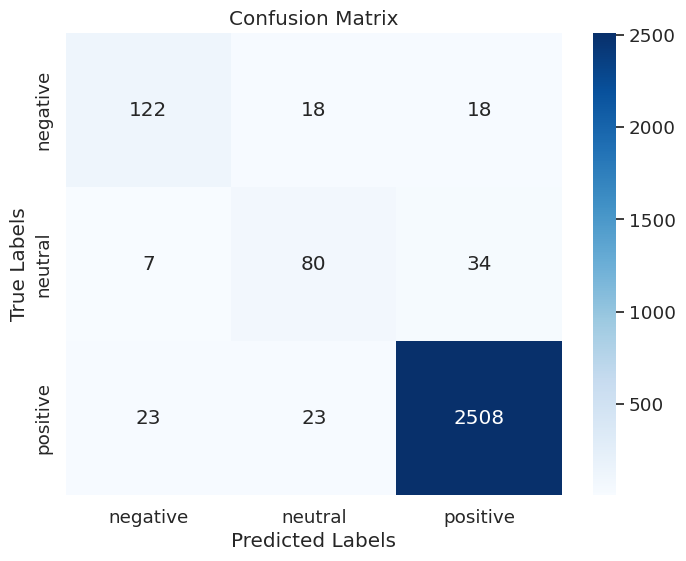

In [50]:
import seaborn as sns
# Plot confusion matrix
labels = ['negative', 'neutral', 'positive']  # Assuming these are your class labels
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


<Figure size 640x480 with 0 Axes>

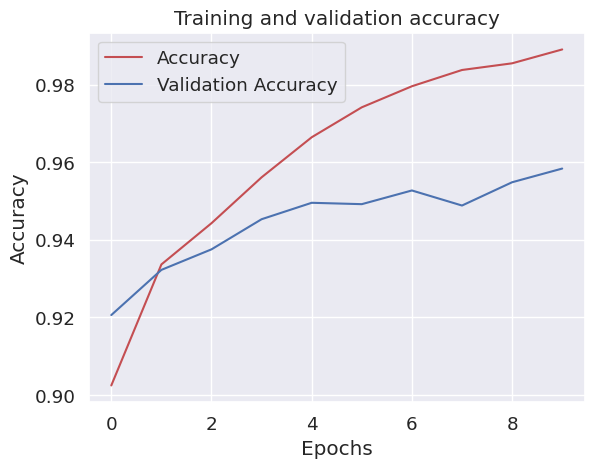

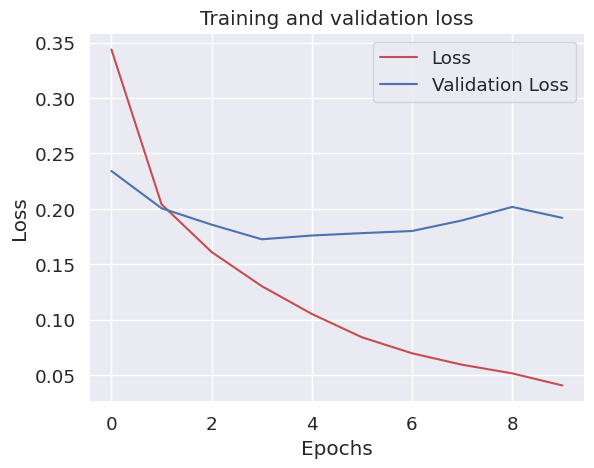

<Figure size 640x480 with 0 Axes>

In [51]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [52]:
model.save('/content/drive/MyDrive/lstm')